## Generate correlated features (mimicking GC content, BGS and gBGC) 

Text(0, 0.5, 'x2')

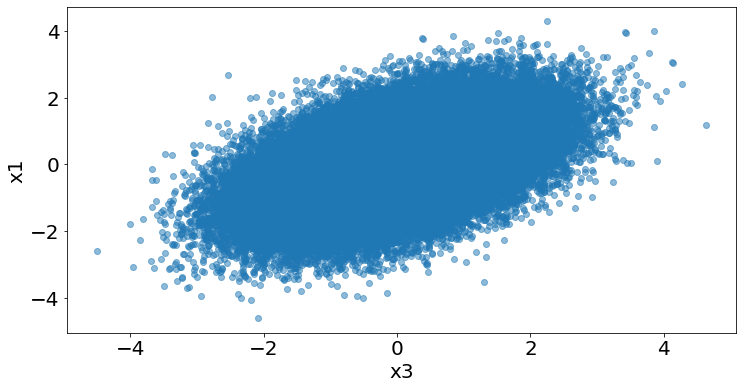

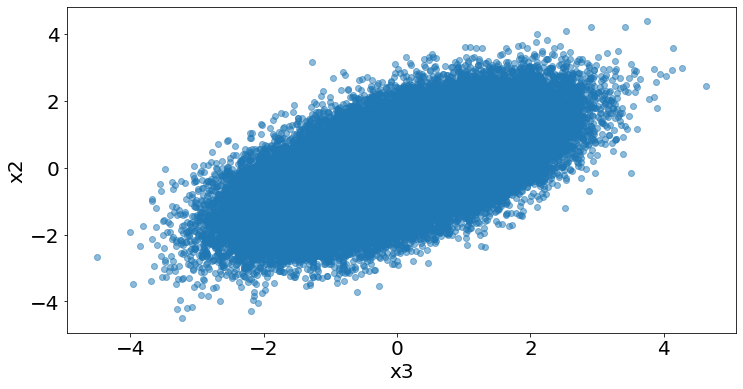

In [14]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

plt.rcParams.update({'font.size': 20})

NUMBER_EXAMPLES = 100000 # Number of intervals

MEAN = [0, 0, 0]  # Means for the three features

# Covariance matrix (symmetric and positive-definite)
# we need non-zero covariances to exhibit the bias in residuals as a function of x1, but not as a function of x2
COV = [
    [1.0, 0.8, 0.5],  # Variance of X1 and covariances with X2 and X3
    [0.8, 1.0, 0.6],  # Covariance of X2 with X1 and variance of X2 and covariance with X3
    [0.5, 0.6, 1.0]   # Covariance of X3 with X1 and X2 and variance of X3
]
# COV = [
#     [1.0, 0.0, 0.0],  # Variance of X1 and covariances with X2 and X3
#     [0.0, 1.0, 0.0],  # Covariance of X2 with X1 and variance of X2 and covariance with X3
#     [0.0, 0.0, 1.0]   # Covariance of X3 with X1 and X2 and variance of X3
# ]

x1s, x2s, x3s = np.random.multivariate_normal(MEAN, COV, size=NUMBER_EXAMPLES).T

# x2s = -0.2 * x2s**2 
# x3s = +0.05 * x3s**3

plt.figure(figsize=(12, 6))
plt.plot(x3s, x1s, 'o', alpha=0.5)
plt.xlabel('x3')
plt.ylabel('x1')

plt.figure(figsize=(12, 6))
plt.plot(x3s, x2s, 'o', alpha=0.5)
plt.xlabel('x3')
plt.ylabel('x2')

## True mapping from features to target (mimicking SNV counts)

To be concrete, suppose: 

* x1 is CpG-ness (observed) 
* x2 is mothers' ages, averaged over all generations since MCRA (unobserved)
* x3 is GC_content (observed) 

Though x3 is correlated with x1 and x2, x3 does not directly affect mutation rate. Later, we will fit data using the variables we can observe: x1 and x3. 

Text(0, 0.5, 'number of examples')

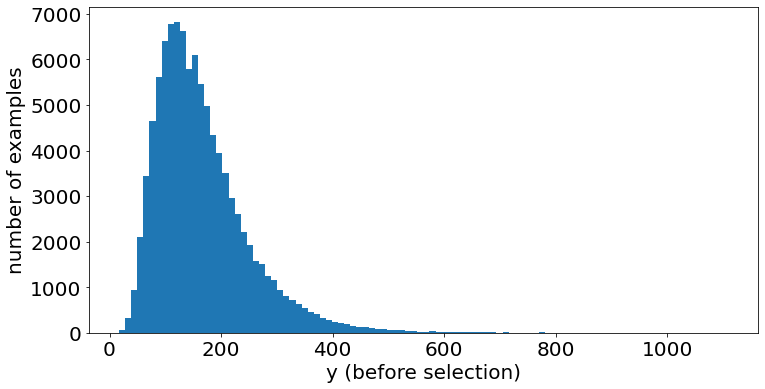

In [16]:
# parameters of true model 
A = 5 
B1 = 0.2 # 0.05 
B2 = 0.3

TRUE_RATE = lambda x1, x2: np.exp(A + B1*x1 + B2*x2) # rate function

ys = np.random.poisson(lam=TRUE_RATE(x1s, x2s)) # target 

plt.figure(figsize=(12, 6))
plt.hist(ys, bins=100)
plt.xlabel('y (before selection)')
plt.ylabel('number of examples')

## Introduce selection into a small fraction of examples

In [17]:
# Take x% of the examples, declare them to be positive examples, and reduce their y values (possibly in proportion to x1), 
# to mimic the effect of negative selection (and how it occurs more often in regions with higher GC content)

# Take the remaining examples, declare them to be neutral (negative) examples, and do not change their y values

POSITIVE_FRACTION = 0.2
FRACTIONAL_REDUCTION_IN_Y = 0.1

num_pos = int(POSITIVE_FRACTION*NUMBER_EXAMPLES)
# x1_factor = (x1s - x1s.min()) / (x1s.max() - x1s.min())
# y_pos = ys[:num_pos] * (1 - max_fractional_reduction_in_y * x1_factor[:num_pos])
y_pos = ys[:num_pos] * (1 - FRACTIONAL_REDUCTION_IN_Y)
y_neg = ys[num_pos:]
ys = np.concatenate([y_pos, y_neg])

constrained = num_pos*[True] + (NUMBER_EXAMPLES-num_pos)*[False]

DATA = pd.DataFrame({'x1': x1s, 'x2': x2s, 'x3': x3s, 'y': ys, 'constrained': constrained})
DATA

,x1,x2,x3,y,constrained
0,-0.161504,-1.111045,-1.196630,90.9,True
1,-0.970296,-0.154861,0.515041,104.4,True
2,-0.966801,-0.333152,-0.601463,87.3,True
3,0.035656,-0.824559,-1.141630,99.0,True
4,0.425004,0.812797,1.936205,177.3,True
...,...,...,...,...,...
99995,0.264280,1.326672,0.518901,258.0,False
99996,0.635441,0.877147,0.457031,226.0,False
99997,0.618846,0.093244,-0.187411,189.0,False
99998,0.940105,0.668417,-0.871083,218.0,False


<AxesSubplot:xlabel='x3', ylabel='y'>

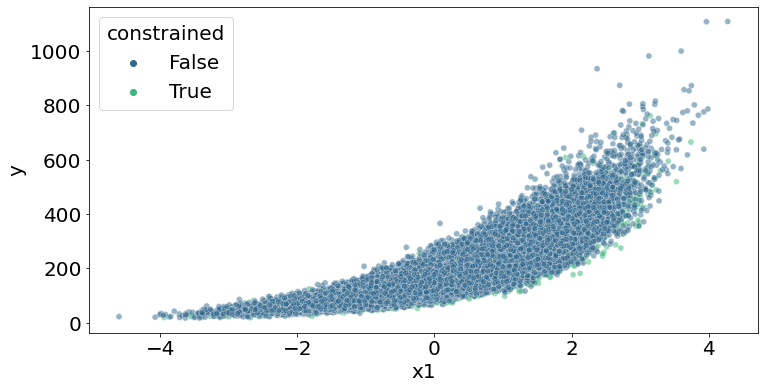

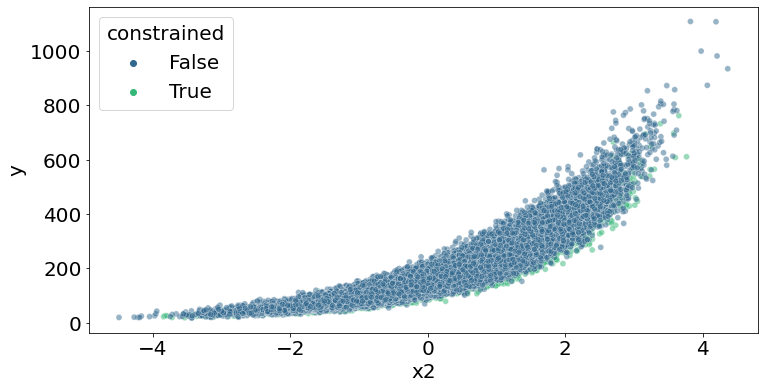

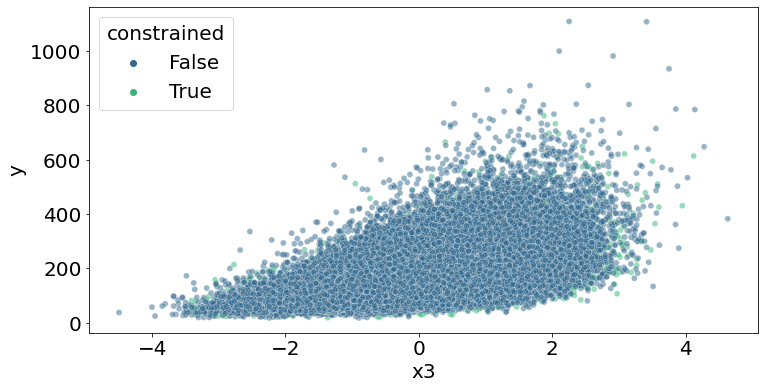

In [18]:
import seaborn as sns

plt.figure(figsize=(12, 6))
sns.scatterplot(data=DATA, x='x1', y='y', hue='constrained', palette='viridis', alpha=0.5)

plt.figure(figsize=(12, 6))
sns.scatterplot(data=DATA, x='x2', y='y', hue='constrained', palette='viridis', alpha=0.5)

plt.figure(figsize=(12, 6))
sns.scatterplot(data=DATA, x='x3', y='y', hue='constrained', palette='viridis', alpha=0.5)


## Approximate models of neutral data

In [24]:
import statsmodels.api as sm

def fit_poisson_model(features, model_index):
    data_neg = DATA[DATA['constrained'] == 0]
    x_model_neg = sm.add_constant(data_neg[features])
    model = sm.Poisson(data_neg['y'], x_model_neg).fit()
    x_model = sm.add_constant(DATA[features])
    DATA[f'predicted_y_model{model_index}'] = model.predict(x_model)
    DATA[f'standardized_residuals_model{model_index}'] = (
        DATA[f'predicted_y_model{model_index}'] - DATA['y'] 
    ) / np.sqrt(DATA[f'predicted_y_model{model_index}'])
    return model.params

# Fit Poisson Model 1: y ~ x1 (one of the two observed features)
coefficients_model1 = fit_poisson_model(['x1'], model_index=1)
print("Coefficients for Model 1:", coefficients_model1)

# Fit Poisson Model 2: y ~ x1 + x3 (both observed features)
coefficients_model2 = fit_poisson_model(['x1', 'x3'], model_index=2)
print("Coefficients for Model 2:", coefficients_model2)

# Fit Poisson Model 3: y ~ x1 + x2 (truth; the two features that directly affect mutation rate)
coefficients_model3 = fit_poisson_model(['x1', 'x2'], model_index=3)
print("Coefficients for Model 3:", coefficients_model3)

DATA

Optimization terminated successfully.
         Current function value: 6.611133
         Iterations 5
Coefficients for Model 1: const    5.016239
x1       0.439678
dtype: float64
Optimization terminated successfully.
         Current function value: 6.208204
         Iterations 5
Coefficients for Model 2: const    5.014056
x1       0.400024
x3       0.080318
dtype: float64
Optimization terminated successfully.
         Current function value: 3.924565
         Iterations 5
Coefficients for Model 3: const    5.000284
x1       0.200311
x2       0.299621
dtype: float64


,x1,x2,x3,y,constrained,predicted_y_model1,standardized_residuals_model1,predicted_y_model2,standardized_residuals_model2,predicted_y_model3,standardized_residuals_model3
0,-0.161504,-1.111045,-1.196630,90.9,True,140.503043,4.184711,128.167819,3.291884,103.032115,1.195226
1,-0.970296,-0.154861,0.515041,104.4,True,98.457085,-0.598930,106.408083,0.194668,116.690361,1.137751
2,-0.966801,-0.333152,-0.601463,87.3,True,98.608519,1.138803,97.417415,1.025065,110.697821,2.223852
3,0.035656,-0.824559,-1.141630,99.0,True,153.226340,4.380701,139.299549,3.414486,116.789285,1.646103
4,0.425004,0.812797,1.936205,177.3,True,181.835795,0.336367,208.424992,2.155928,206.220898,2.013935
...,...,...,...,...,...,...,...,...,...,...,...
99995,0.264280,1.326672,0.518901,258.0,False,169.429564,-6.804468,174.417443,-6.328790,232.926058,-1.642909
99996,0.635441,0.877147,0.457031,226.0,False,199.462991,-1.878974,201.332057,-1.738507,219.287016,-0.453324
99997,0.618846,0.093244,-0.187411,189.0,False,198.012969,0.640503,189.911358,0.066132,172.808430,-1.231704
99998,0.940105,0.668417,-0.871083,218.0,False,228.054122,0.665772,204.416109,-0.950094,218.955634,0.064582


In [27]:
def plot_ys(constrained, feature):
    df = DATA[DATA['constrained'] == constrained]

    plt.figure(figsize=(20, 6))

    plt.subplot(1, 3, 1)
    plt.plot(df[feature], df['y'], 'o', alpha=0.5, label='True y')
    plt.plot(df[feature], df['predicted_y_model1'], 'o', alpha=0.5, label='Predicted y')
    plt.xlabel(feature)
    plt.title('Model 1')
    plt.legend()

    plt.subplot(1, 3, 2)
    plt.plot(df[feature], df['y'], 'o', alpha=0.5, label='True y')
    plt.plot(df[feature], df['predicted_y_model2'], 'o', alpha=0.5, label='Predicted y')
    plt.xlabel(feature)
    plt.title('Model 2')
    plt.legend()

    plt.subplot(1, 3, 3)
    plt.plot(df[feature], df['y'], 'o', alpha=0.5, label='True y')
    plt.plot(df[feature], df['predicted_y_model3'], 'o', alpha=0.5, label='Predicted y')
    plt.xlabel(feature)
    plt.title('Model 3')
    plt.legend()

def plot_ys_all(constrained):
    plot_ys(constrained, 'x1')
    plot_ys(constrained, 'x2')
    plot_ys(constrained, 'x3')

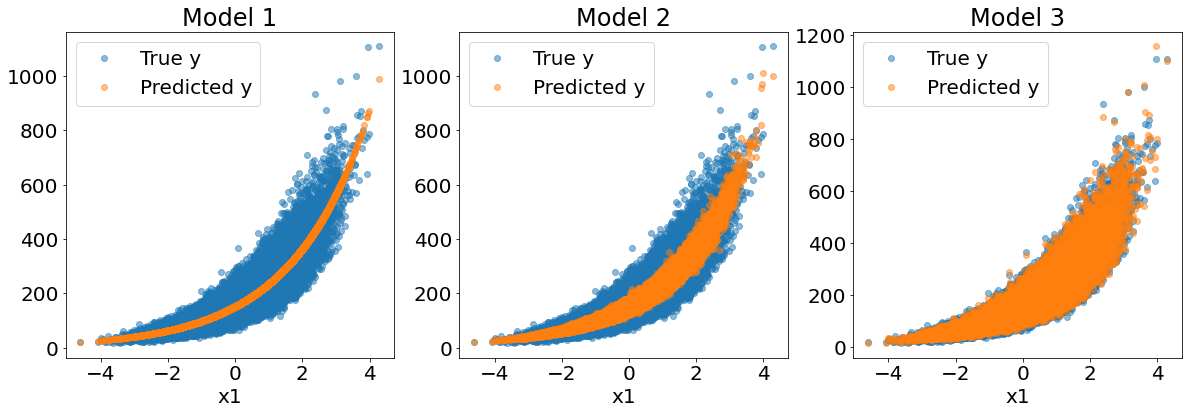

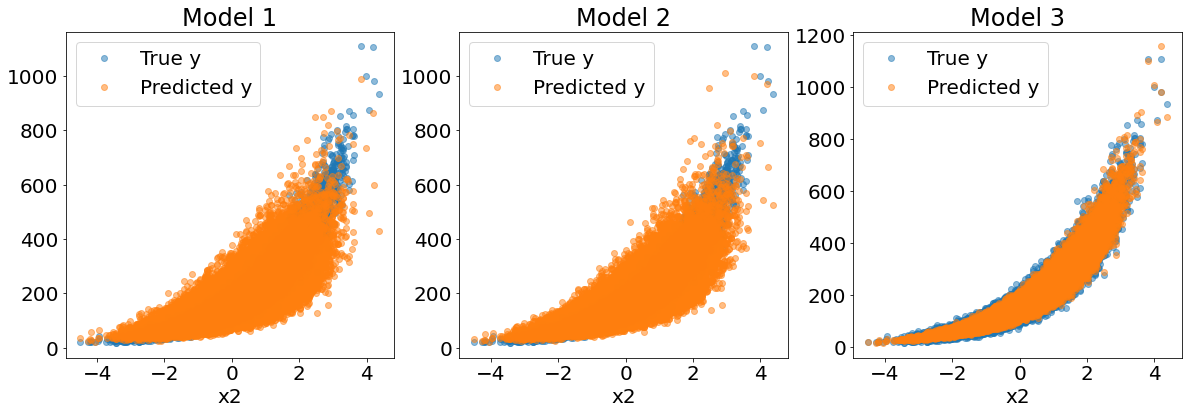

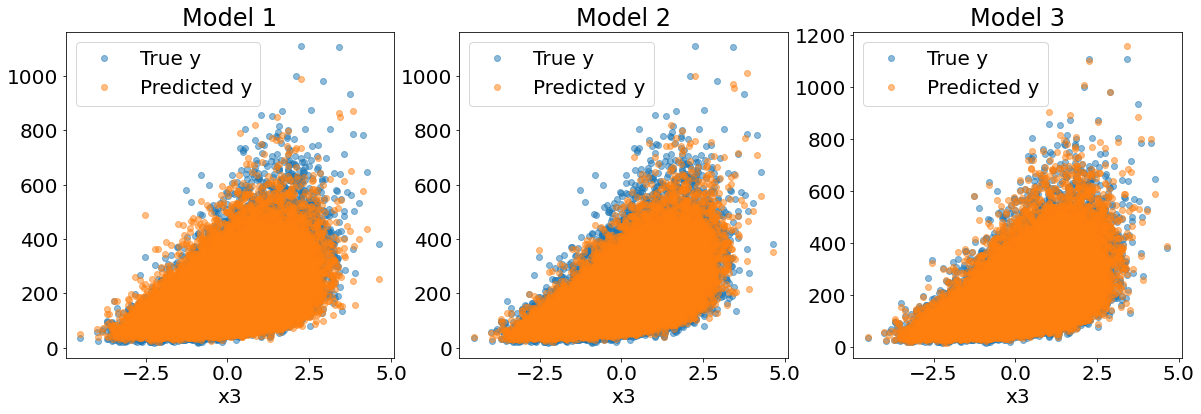

In [28]:
plot_ys_all(constrained=False)

## Variations in model complexity can result in radically different residual patterns

.. even when features are independent of one another (which can be confirmed by re-running the notebook but with COV equal to the identity matrix)

In [31]:
def plot_residuals(constrained, model_index, stratification_feature):
    df = DATA[DATA['constrained'] == constrained].copy()

    df[f'{stratification_feature}_bin_midpoints'] = (pd
        .cut(df[stratification_feature], bins=20, labels=None)
        .apply(lambda x: (x.right + x.left) / 2)
    )
    average_residual = df.groupby(f'{stratification_feature}_bin_midpoints')[f'standardized_residuals_model{model_index}'].mean()  

    plt.subplot(1, 3, model_index)
    plt.scatter(df[stratification_feature], df[f'standardized_residuals_model{model_index}'], alpha=0.7, label='standardized residuals')
    plt.plot(average_residual.index, average_residual.values, color='red', lw=2, label=f'average') 
    plt.axhline(0, color='black', linestyle='--')
    plt.title(f'Model {model_index}')
    plt.xlabel(stratification_feature)
    plt.ylim(-10, 10)
    plt.legend()

def plot_residuals_wrapper(constrained, stratification_feature):
    plt.figure(figsize=(20, 6))
    plot_residuals(constrained, model_index=1, stratification_feature=stratification_feature)
    plot_residuals(constrained, model_index=2, stratification_feature=stratification_feature)
    plot_residuals(constrained, model_index=3, stratification_feature=stratification_feature)


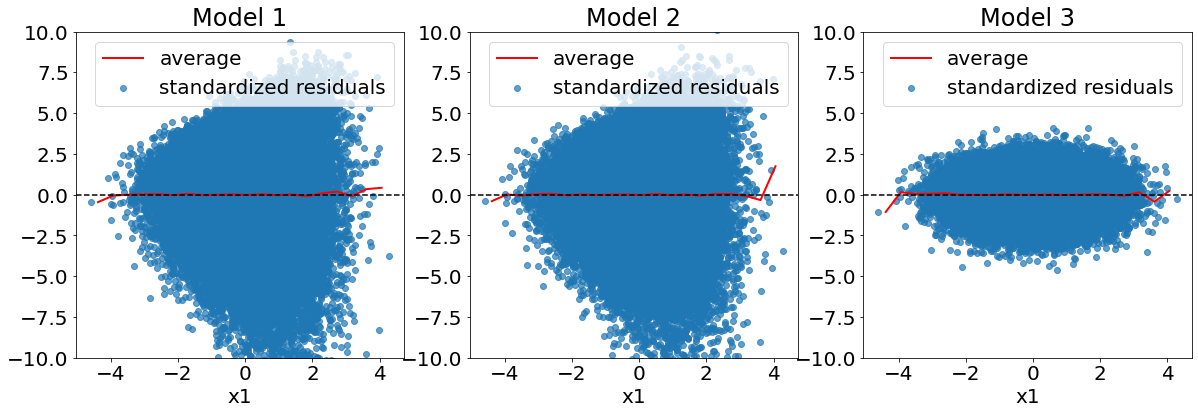

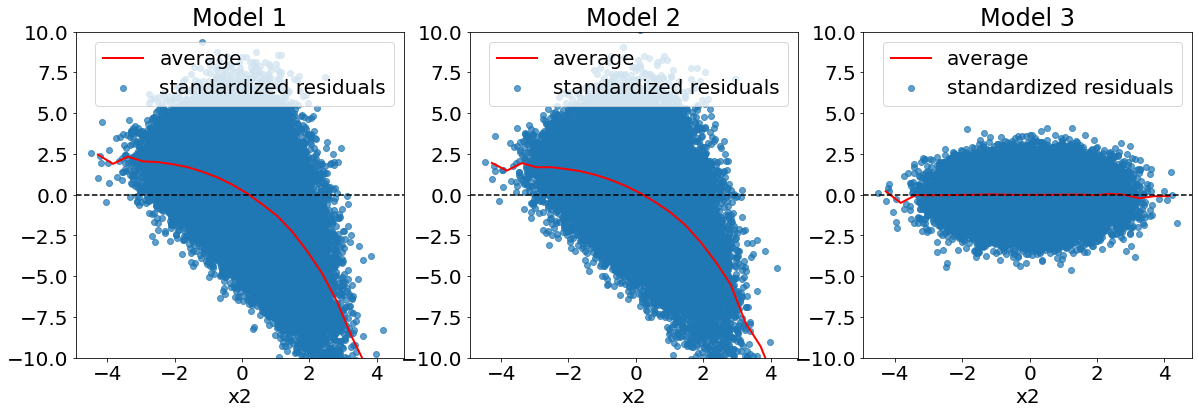

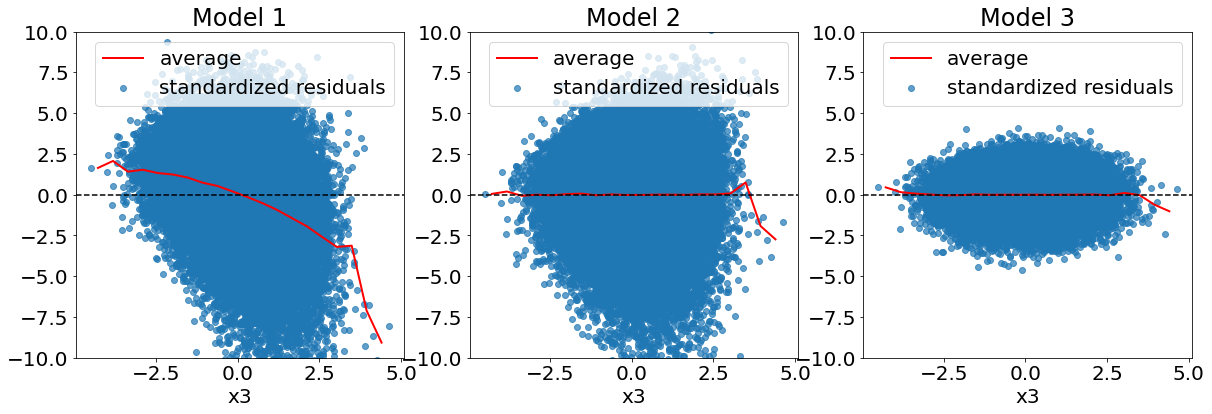

In [32]:
plot_residuals_wrapper(constrained=False, stratification_feature='x1')
plot_residuals_wrapper(constrained=False, stratification_feature='x2')
plot_residuals_wrapper(constrained=False, stratification_feature='x3')

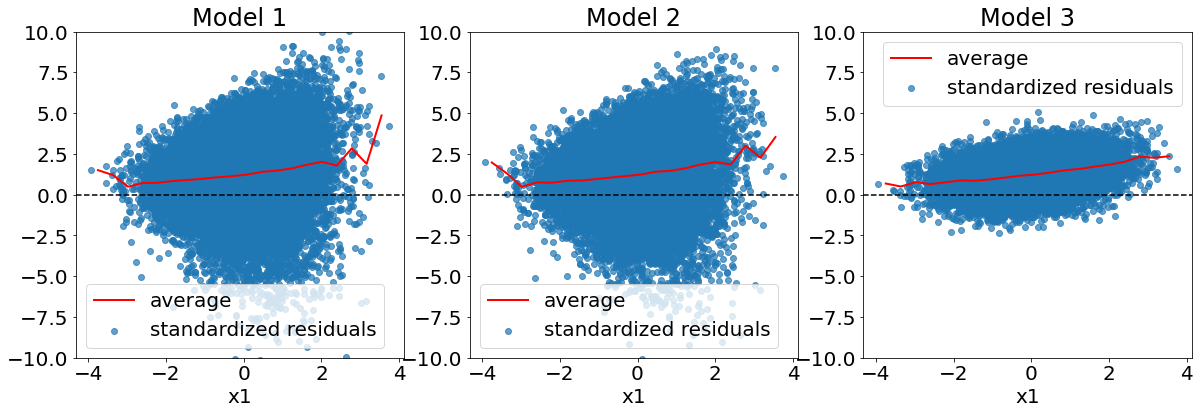

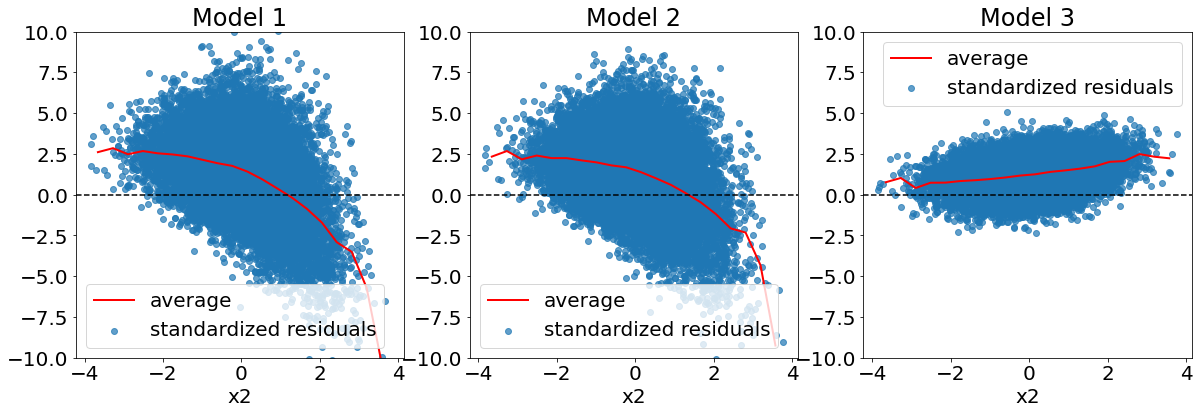

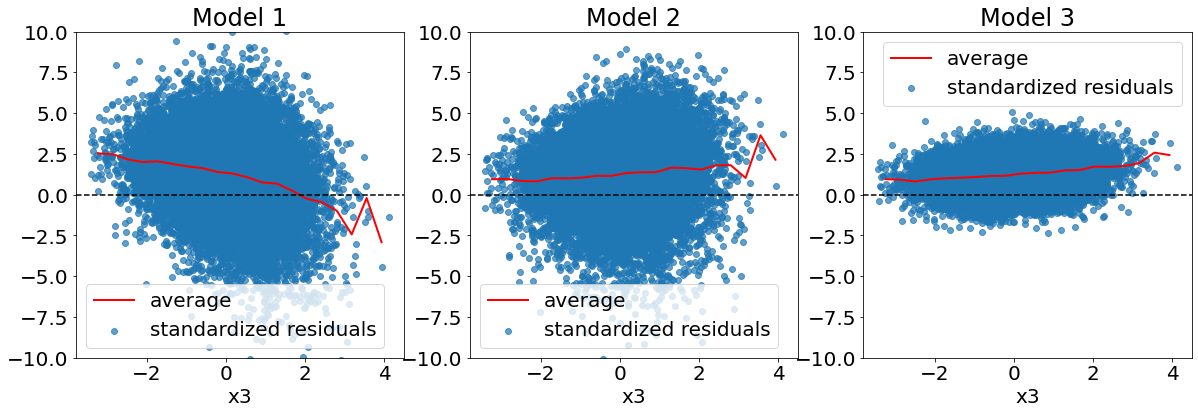

In [33]:
plot_residuals_wrapper(constrained=True, stratification_feature='x1')
plot_residuals_wrapper(constrained=True, stratification_feature='x2')
plot_residuals_wrapper(constrained=True, stratification_feature='x3')

## Estimating the direct effect of each feature on model bias 

In [34]:
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import StandardScaler

def compute_bias_effect_sizes(constrained, model_index): 
    df = DATA[DATA['constrained'] == constrained].copy()

    feature_names = ['x1', 'x2', 'x3']
    features = df[feature_names]  
    scaler = StandardScaler()
    standardized_features = scaler.fit_transform(features)

    standardized_residuals = df[f'standardized_residuals_model{model_index}']

    model = LinearRegression()
    model.fit(standardized_features, standardized_residuals)

    print(f"How much direct effect does each feature have on the bias of Model {model_index}?")
    coefficients = model.coef_
    name_max, abs_coef_max = None, 0
    for name, coef in zip(feature_names, coefficients):
        print(f"Effect size of {name}: {coef}")
        if abs(coef) > abs_coef_max:
            name_max, abs_coef_max = name, abs(coef)

    print(
        f"Feature with the largest effect size: "
        f"{name_max} with absolute effect size {abs_coef_max}"
    )

compute_bias_effect_sizes(constrained=False, model_index=1)

How much direct effect does each feature have on the bias of Model 1?
Effect size of x1: 3.0071828833990653
Effect size of x2: -3.76631927959899
Effect size of x3: 0.003735231988317947
Feature with the largest effect size: x2 with absolute effect size 3.76631927959899


In [35]:
compute_bias_effect_sizes(constrained=False, model_index=2)

How much direct effect does each feature have on the bias of Model 2?
Effect size of x1: 2.506115806772272
Effect size of x2: -3.7659966868929384
Effect size of x3: 1.0133703054555285
Feature with the largest effect size: x2 with absolute effect size 3.7659966868929384


In [36]:
compute_bias_effect_sizes(constrained=False, model_index=3)

How much direct effect does each feature have on the bias of Model 3?
Effect size of x1: -0.0018740271918545627
Effect size of x2: 0.0007478199064142089
Effect size of x3: 0.000856569978714986
Feature with the largest effect size: x1 with absolute effect size 0.0018740271918545627


## Variations in model complexity, and bias in the residuals of the positive examples, dictate how performance varies with feature stratum

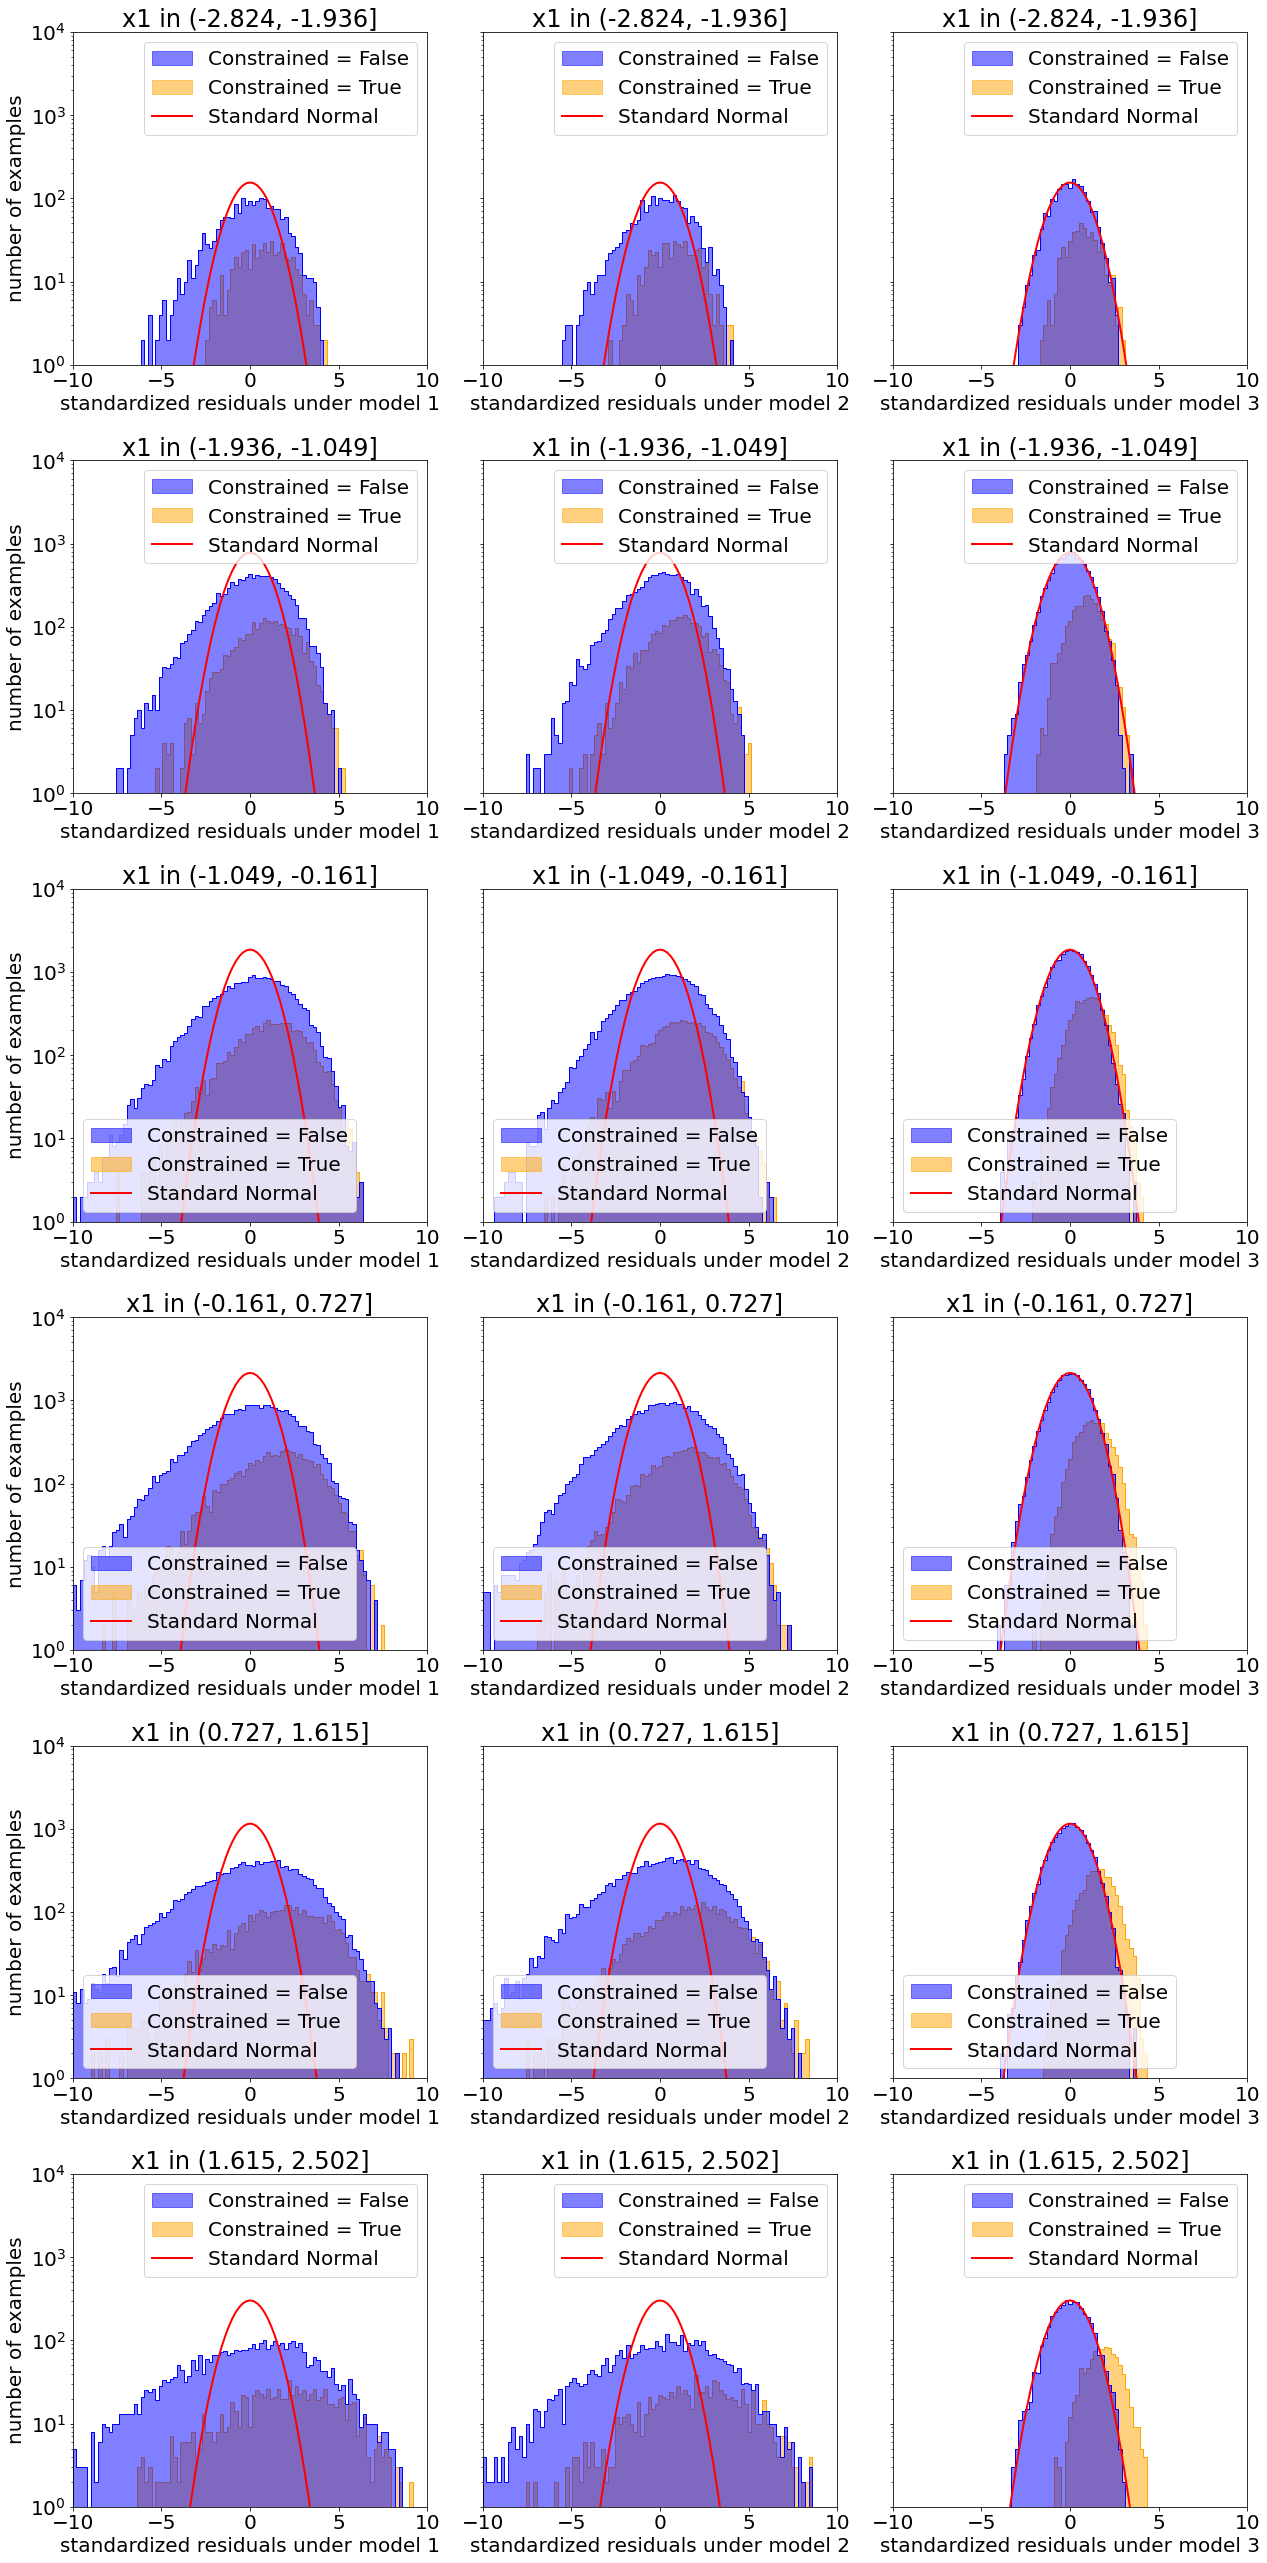

In [37]:
import seaborn as sns
from matplotlib.patches import Patch

NUMBER_EXAMPLES_MIN = 1000

def plot_residual_distributions():
    df = DATA.copy()

    df['x1_bin'] = (pd
        .cut(df['x1'], bins=10, labels=None)
    )
    groups = df.groupby('x1_bin')
    filtered_groups = {x1_bin: group for x1_bin, group in groups if len(group) > NUMBER_EXAMPLES_MIN}

    fig, axes = plt.subplots(len(filtered_groups), 3, figsize=(18, 6 * len(filtered_groups)), sharey=True)
    
    for i, (x1_bin, group) in enumerate(filtered_groups.items()):        
        for model_index in range(1, 4):
            ax = axes[i, model_index - 1] 

            bins = np.linspace(-10, 10, 100)
            bin_centers = (bins[1:] + bins[:-1]) / 2
            bin_width = bins[1] - bins[0]

            palette = {False: 'blue', True: 'orange'}
            alpha = 0.5  

            sns.histplot(
                data=group, 
                x=f'standardized_residuals_model{model_index}', 
                hue='constrained', 
                kde=False, 
                element='step', 
                bins=bins, 
                ax=ax, 
                palette=palette, 
                alpha=alpha
            )

            # plot standard normal 
            x = bin_centers
            y = np.exp(-x**2/2) / np.sqrt(2*np.pi)
            negative_class_count = len(group[group['constrained'] == False])
            y_scaled = y * negative_class_count * bin_width  
            normal_line, = ax.plot(x, y_scaled, color='red', lw=2)

            ax.set_xlabel(f'standardized residuals under model {model_index}')
            ax.set_ylabel('number of examples')
            ax.set_title(f'x1 in {x1_bin}')
            ax.set_yscale('log')  
            ax.set_xlim(-10, 10)
            ax.set_ylim(1, 1e4)

            # Manually create legend handles and labels
            handles = [
                Patch(color=palette[False], alpha=alpha),
                Patch(color=palette[True], alpha=alpha),
                normal_line
            ]
            labels = [
                'Constrained = False', 
                'Constrained = True', 
                'Standard Normal'
            ]
            ax.legend(handles=handles, labels=labels)

    plt.tight_layout()
    plt.show()

plot_residual_distributions()

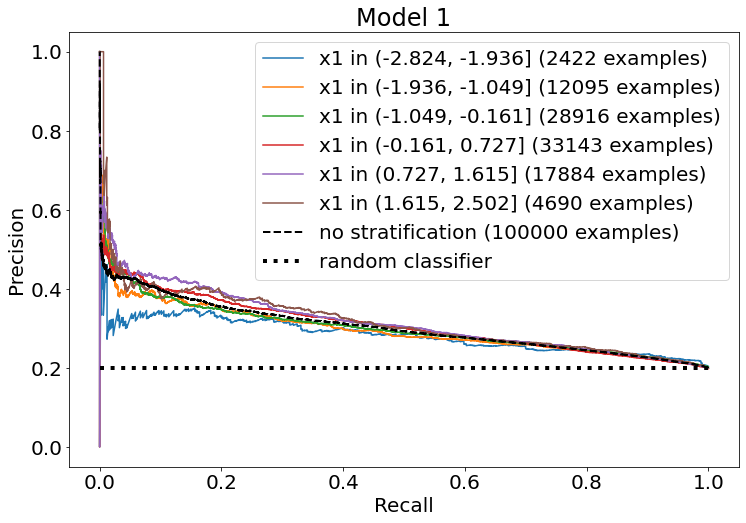

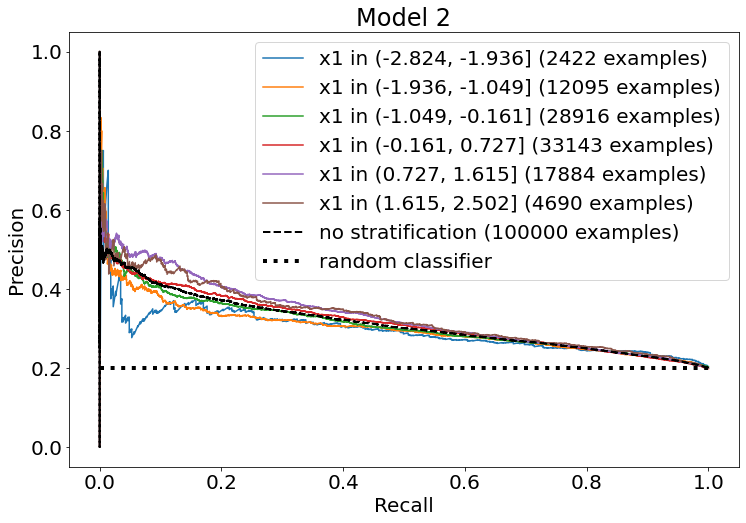

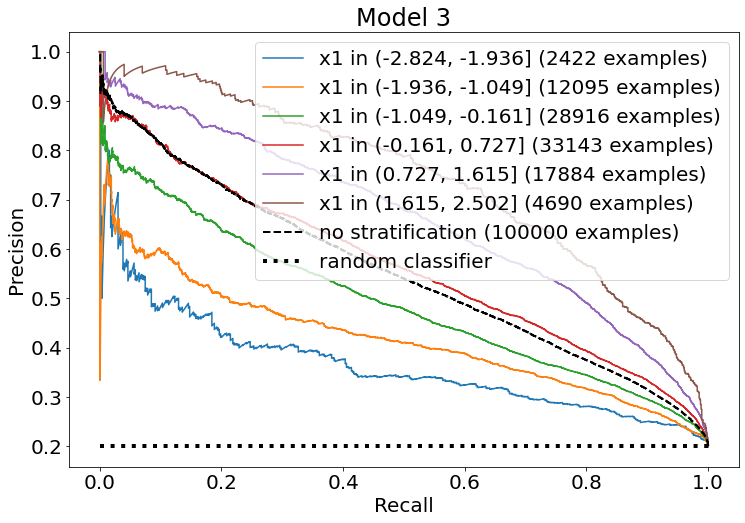

In [38]:
from sklearn.metrics import precision_recall_curve

def plot_pr_curves(model_index, stratification_feature):
    df = DATA.copy()

    df[f'{stratification_feature}_bin'] = (pd
        .cut(df[stratification_feature], bins=10, labels=None)
    )
    groups = df.groupby(f'{stratification_feature}_bin')

    pr_curves = {}
    for x_bin, group in groups:        
        precision, recall, _ = precision_recall_curve(group['constrained'], group[f'standardized_residuals_model{model_index}'])
        pr_curves[x_bin] = (precision, recall, len(group))

    plt.figure(figsize=(12, 8))
    for x_bin, (precision, recall, num_examples) in pr_curves.items():
        if num_examples > NUMBER_EXAMPLES_MIN:
            plt.plot(recall, precision, label=f'{stratification_feature} in {x_bin} ({num_examples} examples)')

    # no stratification    
    precision, recall, _ = precision_recall_curve(df['constrained'], df[f'standardized_residuals_model{model_index}'])
    plt.plot(recall, precision, label=f'no stratification ({len(df)} examples)', color='black', lw=2, linestyle='--')

    plt.plot([0, 1], [POSITIVE_FRACTION, POSITIVE_FRACTION], color='black', lw=4, linestyle=':', label='random classifier')

    plt.xlabel('Recall')
    plt.ylabel('Precision')
    plt.legend()
    plt.title(f'Model {model_index}')
    plt.show()

def plot_pr_curves_wrapper(stratification_feature):
    plot_pr_curves(model_index=1, stratification_feature=stratification_feature)
    plot_pr_curves(model_index=2, stratification_feature=stratification_feature)
    plot_pr_curves(model_index=3, stratification_feature=stratification_feature)

plot_pr_curves_wrapper(stratification_feature='x1')

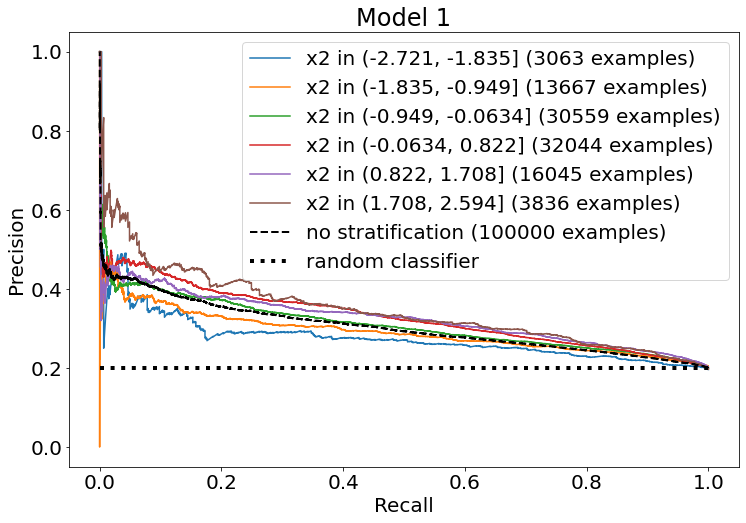

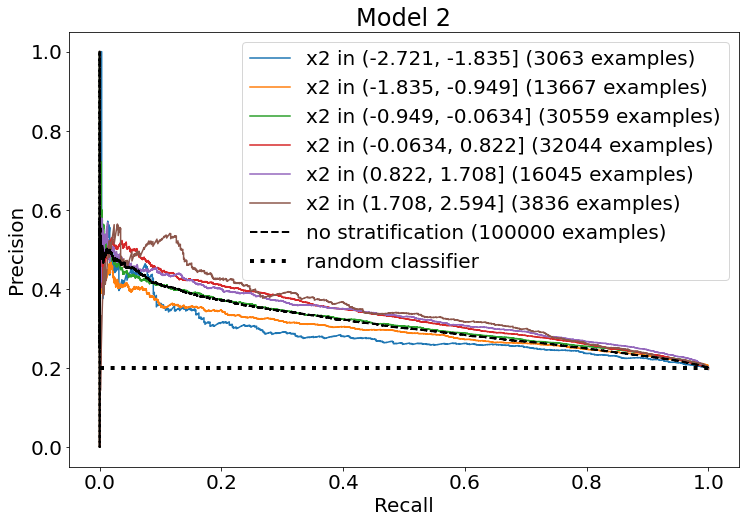

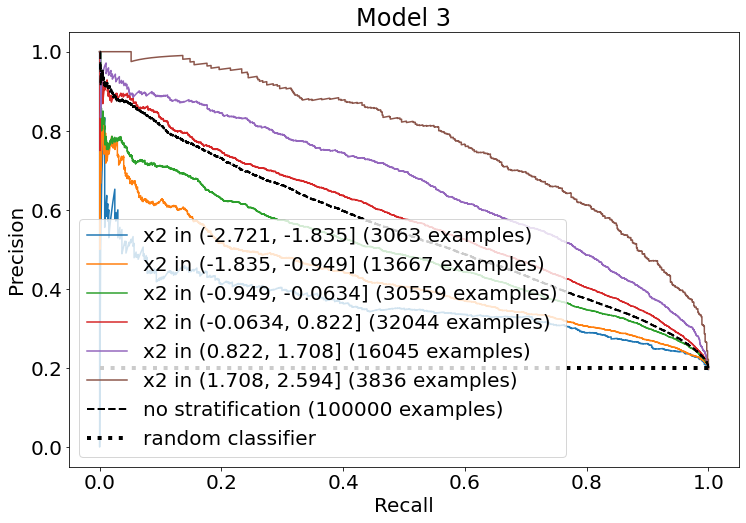

In [39]:
plot_pr_curves_wrapper(stratification_feature='x2')

/uufs/chpc.utah.edu/common/HIPAA/u6018199/.conda/envs/constraint-tools/lib/python3.9/site-packages/sklearn/metrics/_ranking.py:877: UserWarning: No positive class found in y_true, recall is set to one for all thresholds.
  warnings.warn(


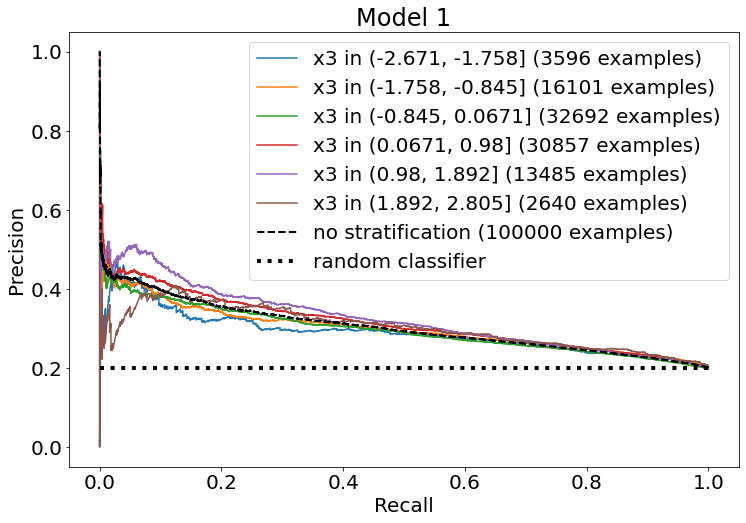

/uufs/chpc.utah.edu/common/HIPAA/u6018199/.conda/envs/constraint-tools/lib/python3.9/site-packages/sklearn/metrics/_ranking.py:877: UserWarning: No positive class found in y_true, recall is set to one for all thresholds.
  warnings.warn(


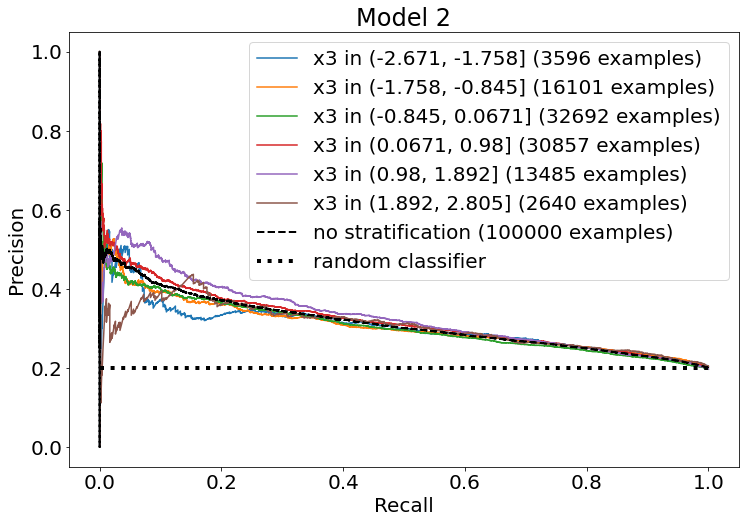

/uufs/chpc.utah.edu/common/HIPAA/u6018199/.conda/envs/constraint-tools/lib/python3.9/site-packages/sklearn/metrics/_ranking.py:877: UserWarning: No positive class found in y_true, recall is set to one for all thresholds.
  warnings.warn(


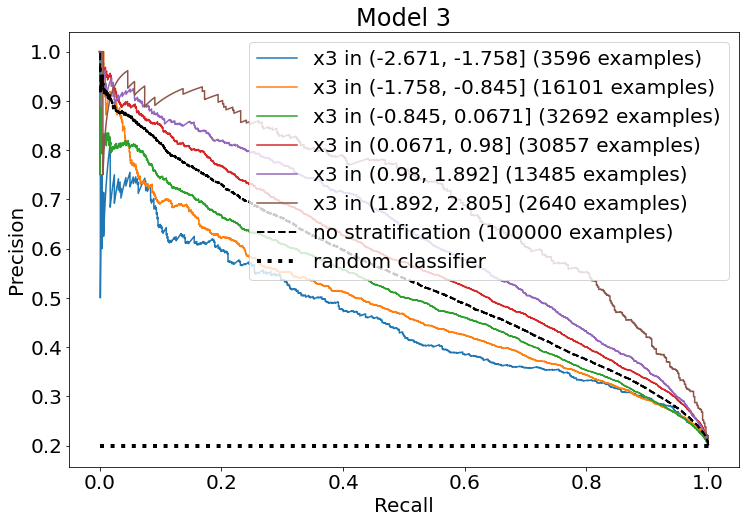

In [40]:
plot_pr_curves_wrapper(stratification_feature='x3')